# Import Data

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
train_ds_raw, test_ds_raw = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteR9FQ4D/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


# Check the Data

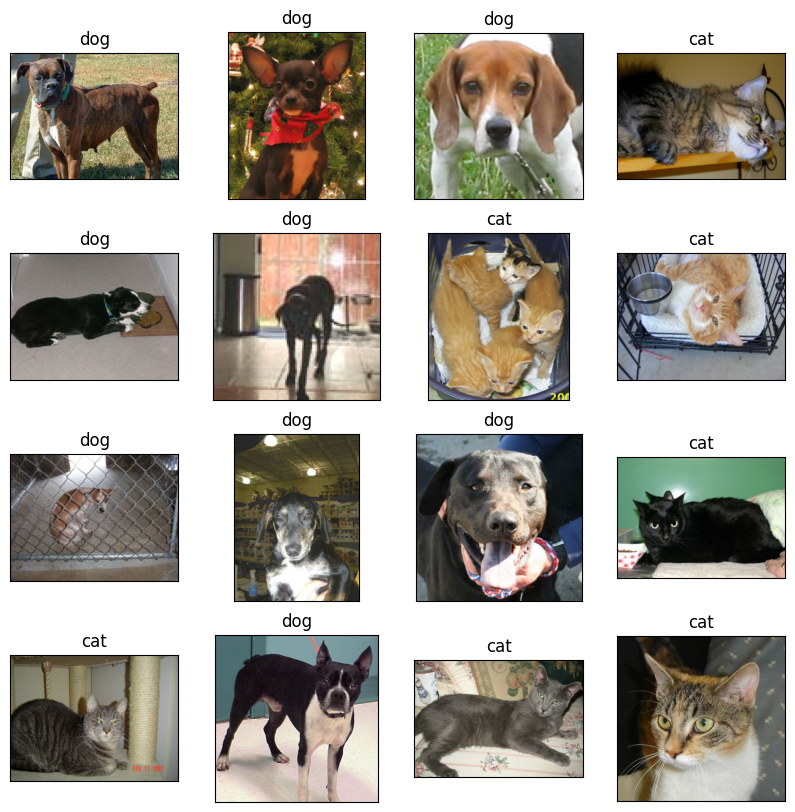

In [3]:
class_names = ['cat', 'dog']

fig = plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds_raw.take(16)):
    ax = fig.add_subplot(4, 4, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image)
    ax.set_title(class_names[label.numpy()])
plt.show()

In [4]:
len(train_ds_raw)       

18610

In [5]:
len(test_ds_raw)

4652

In [2]:
# Define the size of the validation set + batch size
VALIDATION_SIZE = int(len(train_ds_raw)*0.2)
BATCH_SIZE = 32

# Define the preprocessing function as before
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (224, 224))
    return image, label

# Preprocess the training data and split into training and validation sets
train_ds = train_ds_raw.map(preprocess)
train_ds = train_ds.shuffle(buffer_size=len(train_ds))
val_ds = train_ds.take(VALIDATION_SIZE)
train_ds = train_ds.skip(VALIDATION_SIZE)

# Preprocess the test data
test_ds = test_ds_raw.map(preprocess)

# # Batch the data sets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [4]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.Dropout(0.25),  # Add a dropout layer with rate 0.25
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.25),  # Add a dropout layer with rate 0.25
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                    

In [6]:
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_ds,epochs= 10, validation_data=val_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

In [ ]:
prediction = model.predict(test_ds)

# compare with pretrained model


In [7]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (224,224) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [8]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)
pre_model = tf.keras.Model(inputs, outputs)

#now print the model.summary()
pre_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
metrics = tf.keras.metrics.BinaryAccuracy()

pre_model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[metrics],
)

epochs = 20

pre_history = pre_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20


In [ ]:
pre_history.history.keys()

In [ ]:
acc = pre_history.history['binary_accuracy']
val_acc = pre_history.history['val_binary_accuracy']

loss = pre_history.history['loss']
val_loss = pre_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = pre_model.evaluate(test_ds)

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

## As expected, pretrained model is much better...
now let's unfreeze the model and train again

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
after_unfreeze_model = pre_model #  copy the model
base_model.trainable = True 
after_unfreeze_model.summary()

after_unfreeze_model.compile(
    optimizer= tf.keras.optimizers.Adam(1e-5),#use Adam with a low learning rate of 1e-5 for fine-tuning weights, 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[metrics],
)

#train for 10 epochs now
epochs = 10
final_history = after_unfreeze_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

In [ ]:
test_loss, test_accuracy = after_unfreeze_model.evaluate(test_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

In [ ]:
rst = after_unfreeze_model.predict(test_ds)

In [ ]:
rst.max()

In [ ]:
rst.min()

In [ ]:
binary_prediction = (rst >= 0).astype(int)

In [ ]:
p = binary_prediction[0]

p[0]

# check the prediction is right

In [ ]:
class_names = ['cat', 'dog']

fig = plt.figure(figsize=(15, 15))
for i, (image, label) in enumerate(test_ds_raw.take(81)):
    ax = fig.add_subplot(9, 9, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image)
    ax.set_title(class_names[binary_prediction[i][0]])
plt.show()

# Save the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pre_model.save('/content/drive/MyDrive/sjsu/ML_club/Deploy_flask_demo/model.h5')
pre_model.save('/content/drive/MyDrive/sjsu/ML_club/Deploy_flask_demo/after_unfreeze_model.h5')

In [ ]:
import pickle
pickle.dump(model, open('/content/drive/MyDrive/sjsu/ML_club/Deploy_flask_demo/model.pkl', 'wb'))
pickle.dump(after_unfreeze_model, open('/content/drive/MyDrive/sjsu/ML_club/Deploy_flask_demo/after_unfreeze_model.pkl', 'wb'))